In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


c:\Users\sagam\miniconda3\envs\aquasense\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
df = pd.read_csv("../data/final/master_dataset.csv")

df["dateTime"] = pd.to_datetime(df["dateTime"])
df = df.sort_values("dateTime").reset_index(drop=True)

df.head()


,dateTime,TN,TP,NH3,NO23,OP,SSC
0,1978-06-05,2.51,0.05,0.02,1.8,0.05,247.0
1,1978-07-12,2.13,0.19,0.02,1.3,0.05,359.0
2,1978-08-15,2.47,0.34,0.17,1.5,0.05,367.0
3,1978-09-14,2.40,0.16,0.02,0.6,0.05,159.0
4,1978-10-23,1.98,0.20,0.02,1.3,0.05,196.0


In [3]:
features = ["TP", "NH3", "NO23", "OP", "SSC"]
target = "TN"

data = df[features + [target]]
data.head()


,TP,NH3,NO23,OP,SSC,TN
0,0.05,0.02,1.8,0.05,247.0,2.51
1,0.19,0.02,1.3,0.05,359.0,2.13
2,0.34,0.17,1.5,0.05,367.0,2.47
3,0.16,0.02,0.6,0.05,159.0,2.40
4,0.20,0.02,1.3,0.05,196.0,1.98


In [4]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data[features])
y_scaled = scaler_y.fit_transform(data[[target]])


In [19]:
def create_sequences(X, y, lookback=30):
    X_seq, y_seq = [], []
    
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    
    return np.array(X_seq), np.array(y_seq)


In [21]:
LOOKBACK = 30

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)

X_seq.shape, y_seq.shape


((511, 30, 5), (511, 1))

In [22]:
split = int(0.8 * len(X_seq))

X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


In [23]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, X_seq.shape[2])),
    Dropout(0.2),

    LSTM(32),
    Dropout(0.2),

    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


c:\Users\sagam\miniconda3\envs\aquasense\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)


In [25]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0643 - val_loss: 0.0265
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0386 - val_loss: 0.0269
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0405 - val_loss: 0.0279
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0416 - val_loss: 0.0268
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0386 - val_loss: 0.0269
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0399 - val_loss: 0.0259
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0362 - val_loss: 0.0264
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0382 - val_loss: 0.0255
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0361 - val_loss: 0.0259
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0375 - val_loss: 0.0265
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0340 - val_loss: 0.0251
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

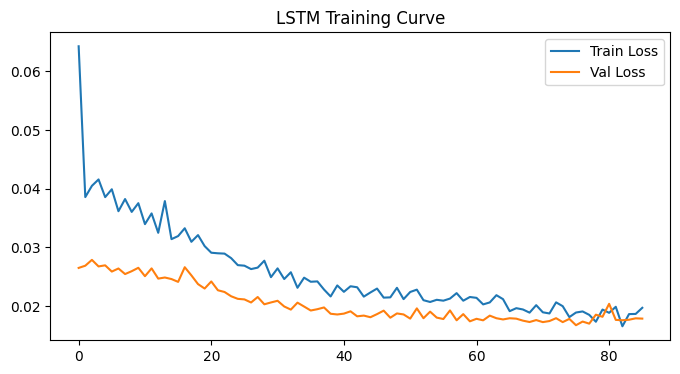

In [26]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("LSTM Training Curve")
plt.show()


In [27]:
y_pred_scaled = model.predict(X_test)

y_test_actual = scaler_y.inverse_transform(y_test)
y_pred_actual = scaler_y.inverse_transform(y_pred_scaled)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


In [28]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print("Improved LSTM RMSE:", rmse)
print("Improved LSTM R2:", r2)


Improved LSTM RMSE: 0.4620192564496867
Improved LSTM R2: 0.2740473296542312


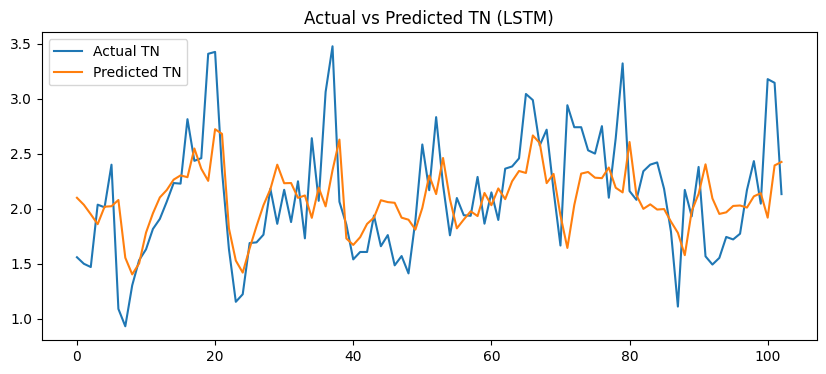

In [29]:
plt.figure(figsize=(10,4))
plt.plot(y_test_actual, label="Actual TN")
plt.plot(y_pred_actual, label="Predicted TN")
plt.legend()
plt.title("Actual vs Predicted TN (LSTM)")
plt.show()
